### Imports and definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pickle, sys, os, json
import astropy.units as u
import pandas as pd
pd.set_option("display.max_columns", None)

from astropy.coordinates import SkyCoord
from matplotlib.dates    import DayLocator, MonthLocator, DateFormatter
from regions             import PointSkyRegion
from astropy.time        import Time
from scipy.stats         import chi2
from IPython.display     import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from gammapy.modeling.models import create_crab_spectral_model, SkyModel, LogParabolaSpectralModel
from gammapy.estimators      import FluxPointsEstimator, LightCurveEstimator, FluxPoints
from gammapy.modeling        import Fit
from gammapy.datasets        import Datasets, SpectrumDataset
from gammapy.makers          import SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker, SafeMaskMaker
from gammapy.maps            import MapAxis, RegionGeom, Map, TimeMapAxis
from gammapy.data            import DataStore

# import scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/lst1_systematics/scripts"))
import auxiliar  as aux
import documents as docs

# ============================ #
# dl3 path where dl3 and index files are
# dl3_dir = "/fefs/aswg/workspace/daniel.morcuende/data/real/DL3/Crab_performance/AllSkyMC_v0.9.9/intensity80/all_nodes/gh_eff_0.7_th_cont_0.7"
dl3_dir = "/fefs/aswg/workspace/juan.jimenez/data/lst1_systematics/dl3"

fname_dict = "objects/dict_sed_and_lc.pkl"
# ============================ #

### Loading configuration files

In [2]:
# reading the configuration from the gammapy configuration file
target_name, n_off_regions, _e_reco, _e_true = docs.load_gammapy_analysis_configuration()

e_reco_min, e_reco_max, e_reco_bin_p_dec = _e_reco["min"], _e_reco["max"], _e_reco["bins_p_dec"]
e_true_min, e_true_max, e_true_bin_p_dec = _e_true["min"], _e_true["max"], _e_true["bins_p_dec"]


Gammapy analysis configuration:



{'target_name': 'crab',
 'n_off_regions': 1,
 'e_reco': {'min': 0.1, 'max': 50, 'bins_p_dec': 5},
 'e_true': {'min': 0.05, 'max': 200, 'bins_p_dec': 10}}

### Loading full datasets

In [3]:
# Opening all the dl3 data in a path
total_data_store = DataStore.from_dir(dl3_dir)

# Taking obs ids
obs_ids = total_data_store.obs_table["OBS_ID"].data
obs_ids = obs_ids[:]

# Then we get the observation information from the total data store
observations = total_data_store.get_observations(
    obs_ids,
    required_irf=["aeff", "edisp", "rad_max"]
)

# Defining target position and ON reion
target_position = SkyCoord.from_name(target_name, frame='icrs')
on_region = PointSkyRegion(target_position)

print(f'Total livetime of observations {total_data_store.obs_table["LIVETIME"].data.sum()/3600:.2f} h')
display(total_data_store.obs_table[:5])

Total livetime of observations 34.20 h


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2914,2020-11-18,03:43:34.195,2020-11-18,04:02:52.571,83.28333273835389,21.78656763343963,14.833854078422519,75.16614592157748,245.1184558734964,83.6333,22.0133,67319014.19521403,67320172.57145381,1158.378688097,1158.376239776611,1110.755623268583,0.9588881724795433,Crab,WOBBLE,1,LST-1,LST-1
2929,2020-11-19,01:41:13.092,2020-11-19,01:59:21.736,83.97361170669024,22.24478461554191,15.851370353506994,74.148629646493,110.69714313166,83.6333,22.0133,67398073.0916512,67399161.73551226,1088.646086215973,1088.643861055374,1006.045014654632,0.9241249542829353,Crab,WOBBLE,1,LST-1,LST-1
2930,2020-11-19,02:02:55.113,2020-11-19,02:22:43.858,83.26877531593242,21.78654578922968,11.225003496450213,78.77499650354979,126.6188631816417,83.6333,22.0133,67399375.11259389,67400563.8584733,1187.748401165009,1188.745879411697,1107.370648277967,0.9323276269551675,Crab,WOBBLE,1,LST-1,LST-1
2931,2020-11-19,02:24:41.948,2020-11-19,02:44:15.865,83.97560985781382,22.24446090923748,7.970256129037551,82.02974387096245,144.9828160578438,83.6333,22.0133,67400681.94754553,67401855.86502647,1172.932846069336,1173.917480945587,1097.560117693711,0.9357399457025957,Crab,WOBBLE,1,LST-1,LST-1
2932,2020-11-19,02:46:09.185,2020-11-19,03:05:51.191,83.27280949215712,21.77667796720452,7.156094817087634,82.84390518291237,188.4886603553226,83.6333,22.0133,67401969.18531418,67403151.19075465,1181.100458621979,1182.005440473557,1102.793449016734,0.9336999583451118,Crab,WOBBLE,1,LST-1,LST-1


### Defining all the energy axes

In [4]:
# ============================ #
# estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
# ============================ #
# estimated energy axes
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)
# ============================ #
# Energy for the spectrum
e_fit_min = energy_axis.edges[0].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

# ============================ #
# Energy for the lightcurve
e_lc_min = energy_axis.edges[0]
e_lc_max = energy_axis.edges[-1]

print("Spectral fit will be done in energy edges:\n", energy_fit_edges)
print(f"\nLC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

Spectral fit will be done in energy edges:
 [ 0.1         0.15587755  0.24297811  0.37874832  0.5903836   0.9202755
  1.4345029   2.23606798  3.48552798  5.43315563  8.4690699  13.20137869
 20.57798569 32.07645997 50.        ] TeV

LC will be estimated from 0.1 TeV to 50.0 TeV


### We define the geometry regions in te sky and prepare the empty datasets and makers

In [5]:
# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_axis]
)

# creating an empty dataset
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

### Now we analize the ON and OFF regions in the dataset and we store them in `datasets`, then the datasets can be stacked in a unique one

In [6]:
%%time
# The final object will be stored as a Datasets object
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(
        dataset=dataset_empty.copy(name=str(observation.obs_id)),
        observation=observation
    )
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    datasets.append(dataset_on_off) 

# Stacking all the datasets in one
stacked_dataset = Datasets(datasets).stack_reduce()
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : vI9JrYBq 

  Total counts                    : 25569 
  Total background counts         : 21172.00
  Total excess counts             : 4397.00

  Predicted counts                : 23370.50
  Predicted background counts     : 23370.50
  Predicted excess counts         : nan

  Exposure min                    : 2.36e+08 m2 s
  Exposure max                    : 1.33e+09 m2 s

  Number of total bins            : 14 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 868.40

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 21172 
  Acceptance                      : 14 
  Acceptance off                  : 14 

CPU times: user 10.7 s, sys: 2.95 s, total: 13.7 s
Wall time: 21.3 s


### Then we define the model and set inside the dataset

In [7]:
# defining the model we want to fit and the starting values
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
# we will use the crab model in general
model = SkyModel(
    spectral_model=spectral_model, 
    name="crab"
)

# We set the model of all datasets to log parabola
stacked_dataset.models = model

### We fit the model with the stacked dataset

In [8]:
%%time
# Now we run the fit to extract the parameters of the model
fit = Fit()
result = fit.run(datasets=stacked_dataset)
best_fit_model = model.copy()

display(stacked_dataset.models.to_parameters_table())

/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/gammapy/stats/fit_statistics.py:

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,2.9523e-11,cm-2 s-1 TeV-1,1.615e-12,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.4739e+00,,4.376e-02,nan,nan,False,False,
crab,spectral,beta,3.2864e-02,,2.839e-02,nan,nan,False,False,


CPU times: user 1.31 s, sys: 10.1 ms, total: 1.32 s
Wall time: 1.44 s


### Then from the model and the data we can extract the flux points

In [9]:
%%time 
# then extracting the flux points from the data
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    source=target_name, 
    selection_optional="all"
)

# We apply the flux point estiation from the datasets
flux_points = fpe.run(datasets=stacked_dataset)
flux_points.to_table(sed_type="dnde", formatted=True)[:5]

CPU times: user 11 s, sys: 30.3 ms, total: 11 s
Wall time: 11.2 s


e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.125,0.100,0.156,5.188e-09,5.695e-10,5.694e-10,5.693e-10,6.327e-09,83.077,9.115,17135.965222182454,1645.9338,0.000,False,17136.0,True,0.200 .. 5.000,57.270 .. 858.188
0.195,0.156,0.243,1.391e-09,1.294e-10,1.294e-10,1.293e-10,1.650e-09,115.947,10.768,4821.880404080458,999.7856,0.000,False,4822.0,True,0.200 .. 5.000,70.070 .. 2107.584
0.303,0.243,0.379,5.142e-10,3.982e-11,3.988e-11,3.976e-11,5.942e-10,168.436,12.978,1841.939480159777,704.9021,0.000,False,1842.0,True,0.200 .. 5.000,105.532 .. 2128.443
0.473,0.379,0.590,1.866e-10,1.490e-11,1.495e-11,1.485e-11,2.166e-10,160.150,12.655,893.9967783507389,456.9952,0.000,False,894.0,True,0.200 .. 5.000,103.578 .. 1502.870
0.737,0.590,0.920,7.690e-11,6.207e-12,6.247e-12,6.171e-12,8.950e-11,160.034,12.650,495.95412463440425,320.93793,0.000,False,496.0,True,0.200 .. 5.000,113.338 .. 831.900


### Then we can plot the SED

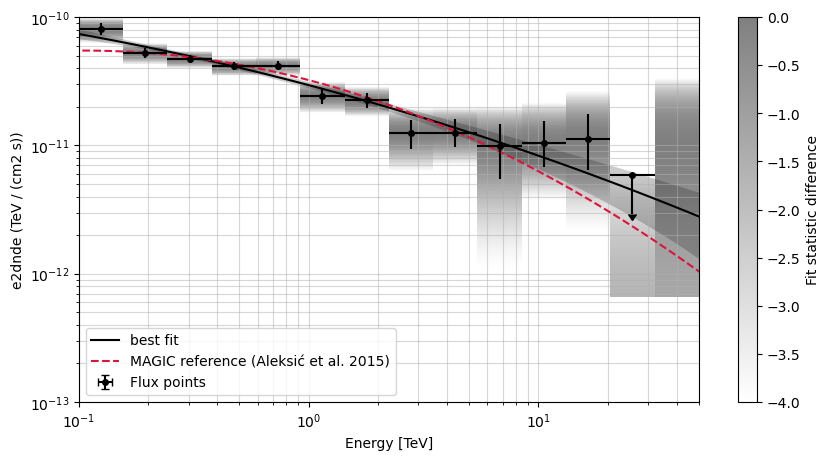

In [10]:
plot_kwargs = {
    "energy_bounds": [0.08, 100] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.TeV,
}
cmap = aux.create_cmap(["w", "gray"])

# Crab models
crab_magic_100 = create_crab_spectral_model("magic_lp")
crab_magic_10  = create_crab_spectral_model("magic_lp")
crab_magic_1   = create_crab_spectral_model("magic_lp")
crab_magic_10.amplitude.value = crab_magic_10.amplitude.value * 0.1
crab_magic_1.amplitude.value  = crab_magic_1.amplitude.value  * 0.01

fig, ax = plt.subplots(figsize=(10,5))


best_fit_model.spectral_model.plot(
    ax=ax, ls="-", lw=1.5, color="k", label="best fit", **plot_kwargs
)

best_fit_model.spectral_model.plot_error(
    ax=ax, facecolor="k", alpha=0.2, **plot_kwargs
)

crab_magic_100.plot(
    ax=ax, ls="--", lw=1.5, color="crimson", label="MAGIC reference (Aleksić et al. 2015)", **plot_kwargs
)
# crab_magic_10.plot(
#     ax=ax, ls="--", lw=1.5, color="crimson", label="Crab 10%", **plot_kwargs
# )
# crab_magic_1.plot(
#     ax=ax, ls="--", lw=1.5, color="crimson", label="Crab 1%", **plot_kwargs
# )

flux_points.plot(sed_type="e2dnde", color="k", label="Flux points")
flux_points.plot_ts_profiles(sed_type="e2dnde", cmap=cmap)

ax.legend(loc=3)
ax.set_ylim([1e-13, 1e-10])
ax.grid(which="both", alpha=0.5)
plt.show()

### Then once we have found the SED model we fix the alpha and beta parameters and let the amplitude as a free parameter

In [11]:
model.parameters["alpha"].frozen = True
model.parameters["beta"].frozen  = True

# Create the LC Estimator for each run
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source="crab", 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

# Assigning the fixed parameters model to each dataset
for data in datasets:
    data.models = model

### Then we run the lightcurve maker run-wise

In [12]:
%%time
print(f"LC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

lc_runwise = lc_maker_1d.run(datasets)
lightcurve = lc_runwise.to_table(sed_type="flux", format="lightcurve")

LC will be estimated from 0.1 TeV to 50.0 TeV
CPU times: user 4.77 s, sys: 15.9 ms, total: 4.78 s
Wall time: 4.8 s


### We calculate the mean flux and the statistical error

### Calculating the means, errors, $\chi^2$ and $p$ values

In [13]:
def weighted_average(table, sys_error=0):
    val = table["flux"]
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    return (val/uncertainty**2).sum() / (1/uncertainty**2).sum(), np.sqrt(1/np.sum(1/uncertainty**2))

mean_flux, mean_flux_err = weighted_average(lightcurve)

def calculate_chi2_pvalue(table, sys_error=0):
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    flux = table["flux"]
    mean_flux = (flux/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    print(f"Weighted mean flux: {mean_flux:.3e} +/- {mean_flux_err:.3e} cm-2 s-1")
    
    chi2_value = np.sum((table["flux"] - mean_flux)**2/uncertainty**2)
    ndf = len(table["flux"]) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    print(f"Chi2: {chi2_value:.1f}, ndf: {ndf}, P-value: {pvalue:.2e}")
    return chi2_value, ndf, pvalue
    
chi2_val, ndf, pvalue = calculate_chi2_pvalue(lightcurve, sys_error=0.0);

Weighted mean flux: 5.374e-10 +/- 1.873e-11 cm-2 s-1
Chi2: 4.6, ndf: 4, P-value: 3.34e-01


### Extracting the data from the table as arrays

In [14]:
# Start time, duration and central time
time_min = Time(np.hstack(lightcurve["time_min"]), format='mjd').datetime
time_max = Time(np.hstack(lightcurve["time_max"]), format='mjd').datetime
delta_time  = time_max - time_min
time_center = time_min + delta_time / 2

# Flux and flux error
flux_lst1 = np.hstack(lightcurve["flux"])
flux_stat_err_lst1 = np.hstack(lightcurve["flux_err"])

# run numbers
run_num = [int(n) for n in observations.ids]

### The Crab Nebula reference from MAGIC

In [15]:
crab = create_crab_spectral_model("magic_lp")

crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)


flux_crab = crab.integral(e_lc_min, e_lc_max)
flux_crab_error = flux_crab * 0

### Plotting the LC

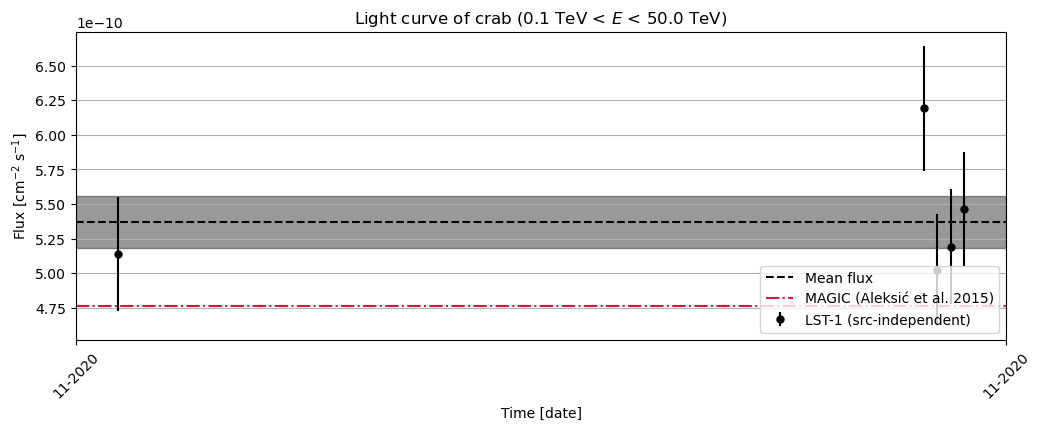

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plotting the Ligt Curve
ax.errorbar(time_center, flux_lst1, yerr=flux_stat_err_lst1, color="k", ls="", marker=".", ms=10, label="LST-1 (src-independent)")
    
# Mean flux + error
ax.axhline(mean_flux, ls="--", color="k", zorder=-1, label="Mean flux")
ax.axhspan(mean_flux - mean_flux_err, mean_flux + mean_flux_err, color="k", alpha=0.4, zorder=-1)

# MAGIC reference
ax.axhline(flux_crab.value, ls="-.", color="crimson", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

energy_range = f"{e_lc_min:.1f} < $E$ < {e_lc_max:.1f}"
ax.set_title(f"Light curve of {target_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Time [date]")
ax.grid()
ax.legend(loc=4)
ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
plt.xticks(rotation=45)


plt.show()

### Plotting the LC run-wise

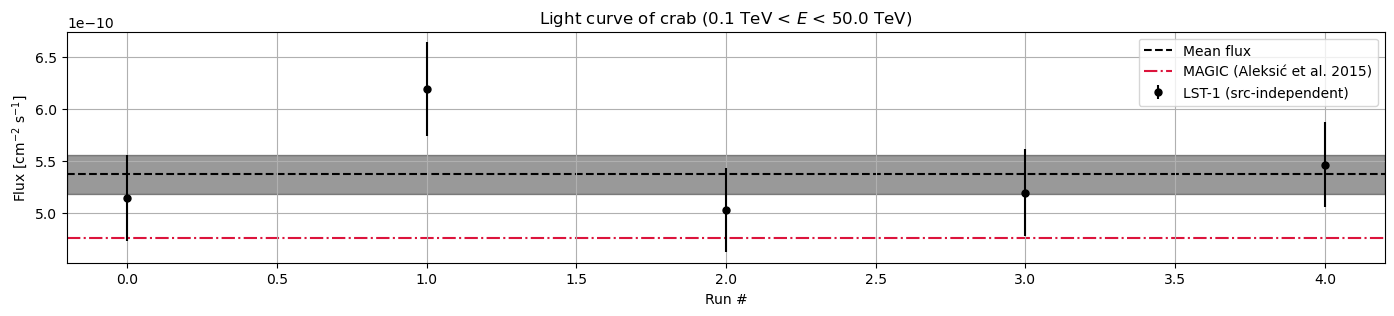

In [17]:
fig, ax = plt.subplots(figsize=(17,3))

# Plotting the Ligt Curve
ax.errorbar(np.arange(len(flux_lst1)), flux_lst1, yerr=flux_stat_err_lst1, color="k", ls="", marker=".", ms=10, label="LST-1 (src-independent)")  

# Mean flux + error
ax.axhline(mean_flux, ls="--", color="k", zorder=-1, label="Mean flux")
ax.axhspan(mean_flux - mean_flux_err, mean_flux + mean_flux_err, color="k", alpha=0.4, zorder=-1)

# MAGIC reference
ax.axhline(flux_crab.value, ls="-.", color="crimson", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

ax.legend()
ax.grid()
ax.set_xlabel(f"Run #")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
energy_range = f"{e_lc_min:.1f} < $E$ < {e_lc_max:.1f}"
ax.set_title(f"Light curve of {target_name} ({energy_range})")
plt.show()

### Now we put all inside a dict and we store it in a file

In [ ]:
dict_total = {
    
    "dict_model" : best_fit_model.to_dict(), # SkyModel.from_dict(<>)
    
    "table_sed"  : flux_points.to_table(),   # FluxPoints.from_table(<>)

    "lightcurve" : {

        "run_number" : run_num,
        "t_start"    : time_min,
        "t_stop"     : time_max,
        "timedelta"  : delta_time,
        "flux"       : flux_lst1,
        "e_flux"     : flux_stat_err_lst1,
        
        "global" : {
            "e_min"               : e_lc_min,
            "e_max"               : e_lc_max,
            "n_off_regions"       : n_off_regions,
            "target_name"         : target_name,
            "crab_reference_flux" : flux_crab,
            "chi2"                : chi2_val,
            "pvalue"              : pvalue
        }
    }
}


# Saving the object
with open(fname_dict, 'wb') as f:
    pickle.dump(dict_total, f, pickle.HIGHEST_PROTOCOL)